In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

%matplotlib inline

In [2]:
# load the entire page
req = requests.get('http://fallout.wikia.com/wiki/Fallout_4_junk_items')
req.status_code

200

In [3]:
# read the output as text
raw = req.text
# load it into BeautifulSoup for parsing
soup = BeautifulSoup(raw, "html.parser")

Select just the second table with the right class

In [4]:
junk_table = soup.select("table.va-table-center")[1]

Load the data row by row

In [5]:
junk_dict = {}

# start from the second table row (to skip the header)
for j in junk_table.findAll('tr')[1:]:
    # select all the table cells
    cells = j.select('td')
    # get item name and components cells
    item_name = cells[0].text.strip()
    components_cell = cells[5]
    # split components text at uppercase letters
    components = [x.strip() for x in re.findall('[A-Z][^A-Z]*', components_cell.text)]
    junk_dict[item_name] = components

Create a pandas DataFrame

NB: there's almost certainly a faster way than adding to the DataFrame row by row

In [6]:
df = pd.DataFrame(columns = ('item', 'component', 'quantity'))
row_idx = 0

for k in junk_dict:
    for c in junk_dict[k]:
        quantity = 1 # default unless otherwise specified
        # extract the multiplier
        multiplier = re.search(' ?x ?([0-9]*)', c)
        component_name = c
        # if the multiplier is specified set the quantity to the right value
        if multiplier:
            if multiplier.group(1) != '':
                quantity = int(multiplier.group(1))
                component_name = c[:-3]
        # add as a row
        df.loc[row_idx] = [k, component_name.strip(), quantity]
        row_idx += 1

Fix some ad-hoc errors

In [7]:
df.loc[df[df['component'] == 'Antisepti'].index,'component'] = 'Antiseptic'
df.loc[df[df['component'] == 'Bone (item)'].index,'component'] = 'Bone'
df.loc[df[df['component'] == 'Wood 2'].index,'component'] = 'Wood'

Export our new dataset

In [8]:
df.to_csv('fallout_junk.csv')

Let's see our components

In [12]:
df['component'].unique()

array(['Plastic', 'Gears', 'Spring', 'Crystal', 'Wood', 'Bone', 'Aluminum',
       'Glass', 'Ceramic', 'Antiseptic', 'Fiberglass', 'Lead', 'Steel',
       'Rubber', 'Nuclear material', 'Circuitry', 'Fiber optics', 'Copper',
       'Silver', 'Cloth', 'Adhesive', 'Leather', 'Oil', 'Asbestos',
       'Screw', 'Acid', 'Cork', 'Gold', 'Ballistic fiber', 'Fertilizer',
       'Concrete'], dtype=object)

And plot!

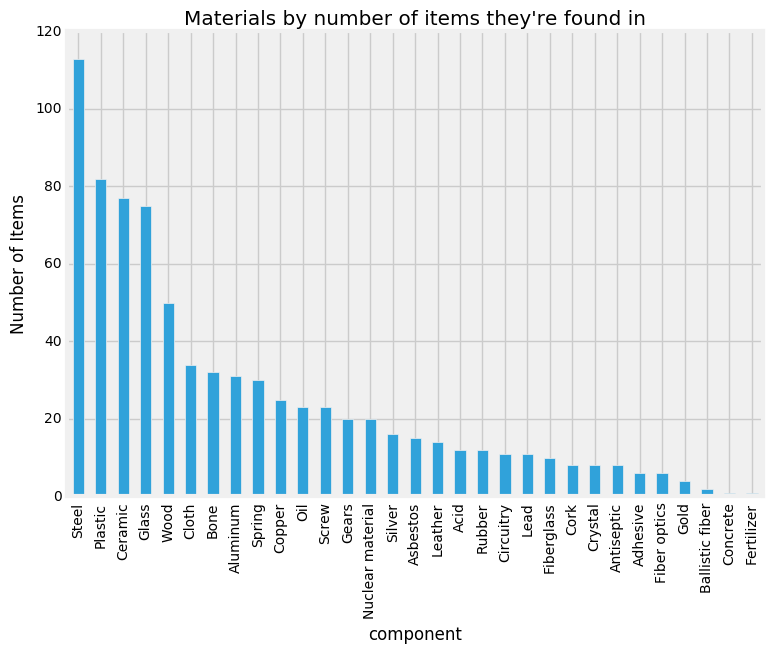

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
t = df.groupby(by='component').count()['item'].sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.set_title('Materials by number of items they\'re found in')
ax.set_ylabel("Component")
ax.set_ylabel("Number of Items")
plt.show()